# READ_ME

- adapated example from Pytorch.Geometric website using GraphSAGE instead of GCN
- datasets from Cora, CiteSeer, PubMed 
- loss function: cross_entropy()  (**note)** the example uses nll instead but this returns a very low accuracy as it requires more preprocessing of the data)
- lr: tried 0.01, 0.001, epoch: tried 200, 500

## libraries

In [3]:
# libraries
import torch
from torch_geometric.data import Data
import pandas as pd 
from torch_geometric.transforms import RandomLinkSplit, RandomNodeSplit  
import torch.nn.functional as F
import torch.nn
from torch_geometric.nn import SAGEConv
import matplotlib.pyplot as plt

#datasets
from torch_geometric.datasets import AttributedGraphDataset
from torch_geometric.datasets import Planetoid 
from torch_geometric.transforms import NormalizeFeatures

# evaluation 
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA

## data

In [7]:
## define transform_nodes
transform_nodes = RandomNodeSplit(split = 'test_rest') # RandomNodeSplit is a class 

In [8]:
# v.3: split into training and testing data points
# v.4: mask one datapoint in the training set and try running again
# caution use data not a dataset 
cora_A_data = transform_nodes(cora_A[0])
citeseer_A_data = transform_nodes(citeseer_A[0])
pubmed_A_data = transform_nodes(pubmed_A[0]) # caution, don't reiterate

## algorithm

In [4]:
# download datasets
datasets = ['cora_A', 'citeseer_A', 'pubmed_A', 'cora_P', 'citeseer_P', 'pubmed_P']

# AGD
cora_A = AttributedGraphDataset(root='AGD', name='Cora')
citeseer_A = AttributedGraphDataset(root='AGD', name='CiteSeer')
pubmed_A =  AttributedGraphDataset(root='AGD', name='PubMed')

# planetoid
cora_P = Planetoid(root='Planetoid', name='Cora', transform=NormalizeFeatures())
citeseer_P = Planetoid(root='Planetoid', name='CiteSeer',transform=NormalizeFeatures())
pubmed_P =  Planetoid(root='Planetoid', name='PubMed',transform=NormalizeFeatures())

In [5]:
#implement a two-layer GraphSage from GCN example:

class GraphSage(torch.nn.Module):
    def __init__(self, attributes, classes, dimension=32):
        super(GraphSage, self).__init__() 
        self.conv1 = SAGEConv(attributes, dimension) 
        self.conv2 = SAGEConv(dimension, classes)
    
    def forward(self, data):
        x, edge_index = data.x, data.edge_index 

        x = self.conv1(x, edge_index) #layer 1 
        x = F.relu(x)
        x = F.dropout(x, training=self.training) #layer 2 
        x = self.conv2(x, edge_index)

        return x

In [32]:
## training & evaluating 

class accuracy():
    def __init__(self, device, dataset, data):
        self.model = GraphSage(dataset.num_node_features, dataset.num_classes).to(device)
        self.data = data
    
    def train(self, num_epochs, lr=0.001, plot_a_graph=False):
        loss_vals= []
        valid_vals= []
        optimizer = torch.optim.Adam(self.model.parameters(), lr, weight_decay=5e-4)
        
        print('             \nTraining the model\n')

        ## training 
        for epoch in range(num_epochs): 
            optimizer.zero_grad()
            out = self.model(self.data)
            loss = F.cross_entropy(out[self.data.train_mask], self.data.y[self.data.train_mask]) 
            loss_vals.append(loss.item()) #record training loss for each epoch
            loss.backward()
            optimizer.step()
            
            # record validation loss for each epoch
            self.model.eval()
            pred = self.model(self.data).argmax(dim=1)        
            correct = (pred[self.data.val_mask] == self.data.y[self.data.val_mask]).sum()
            acc = int(correct) / int(self.data.val_mask.sum())
            valid_vals.append(acc)
        
        if plot_a_graph:
            # plotting the loss vs epochs
            x = range(num_epochs)
            plt.plot(x, loss_vals, linestyle="-")
            plt.plot(x, valid_vals, linestyle="-")
            plt.xlabel("epoch")
            plt.ylabel("loss")
#             plt.show
            return(plt)
    
    def evaluate(self, dimension=1, write_confusion=False):
        # returns a confusion matrix if set write_confusion=True
        print('             \nEvaluating the model\n')
        self.model.eval()
        pred = self.model(self.data).argmax(dimension)        
        correct = (pred[self.data.test_mask] == self.data.y[self.data.test_mask]).sum()
        acc = int(correct) / int(self.data.test_mask.sum())
        print(f'Accuracy: {acc:.4f}')

        if write_confusion: 
            new = confusion_matrix(self.data.y[self.data.test_mask].numpy(), pred[self.data.test_mask].numpy(), normalize='true')
            return(pd.DataFrame(data=new))

In [33]:
## run_pca
def run_pca(data):
    df = pd.DataFrame()
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(data)
    df['pca-one'] = pca_result[:,0]
    df['pca-two'] = pca_result[:,1] 
    display(df)
    X = pca_result.T[0] ##reason for transpose?
    y = pca_result.T[1]
    plt.scatter(X, y, s=100, color="skyblue")

## training
* learning rate = 0.01, 0.001

             
Training the model

             
Evaluating the model

Accuracy: 0.6857


,0,1,2,3,4,5,6
0,0.579545,0.026515,0.037879,0.083333,0.015152,0.068182,0.189394
1,0.018987,0.772152,0.075949,0.031646,0.000000,0.056962,0.044304
2,0.006231,0.034268,0.859813,0.043614,0.015576,0.028037,0.012461
3,0.106646,0.044822,0.032457,0.582689,0.129830,0.068006,0.035549
4,0.067278,0.012232,0.021407,0.042813,0.691131,0.107034,0.058104
5,0.097222,0.037037,0.027778,0.013889,0.032407,0.712963,0.078704
6,0.074074,0.000000,0.022222,0.007407,0.014815,0.066667,0.814815


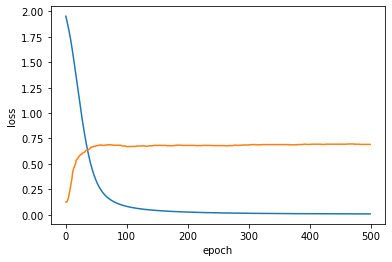

In [9]:
#cora_A 
device1A = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dataset1A = cora_A
data1A = cora_A_data.to(device1A)
cora_A0 = accuracy(device1A, dataset1A, data1A)
cora_A0.train(500, plot_a_graph=True) 
# 7 by 7 matrix (7 classes), each row represents a class, on the columns, predicted group 1 - 7
# e.g. row 1, nothing is predicted to be in group 5 and 6

             
Evaluating the model

Accuracy: 0.6857


,pca-one,pca-two
0,-0.187243,-0.082417
1,0.223984,0.440975
2,0.663299,-0.372954
3,-0.022524,0.134985
4,-0.110265,0.170460
5,-0.147211,0.120079
6,-0.420039,-0.411128


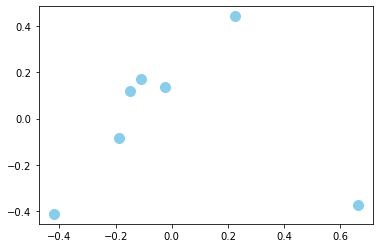

In [36]:
data = cora_A0.evaluate(write_confusion=True)
run_pca(data)

In [41]:
#cora_P
device1P = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dataset1P = cora_P
data1P = cora_P[0].to(device1P)
cora_P0 = accuracy(device1P, dataset1P, data1P)
cora_P0.train(500)
# cora_P0.evaluate() 

             
Training the model



             
Evaluating the model

Accuracy: 0.7980


,pca-one,pca-two
0,-0.240038,-0.008116
1,0.547700,0.324491
2,0.465192,-0.195842
3,-0.054188,-0.316244
4,-0.211610,-0.458057
5,-0.139821,0.164688
6,-0.367235,0.489080


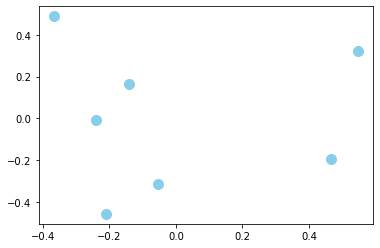

In [42]:
data = cora_P0.evaluate(write_confusion=True)
run_pca(data)

In [43]:
#citeseer_A
device2A = torch.device('cuda ' if torch.cuda.is_available() else 'cpu')
dataset2A = citeseer_A
data2A = citeseer_A_data.to(device2A)
citeseer_A0 = accuracy(device2A, dataset2A, data2A)
citeseer_A0.train(500, True)
# citeseer_A0.evaluate()

             
Training the model



             
Evaluating the model

Accuracy: 0.2385


,pca-one,pca-two
0,-0.056284,-0.034063
1,-0.082069,-0.036431
2,-0.031303,0.140323
3,-0.094016,-0.016296
4,0.339809,-0.014720
5,-0.076137,-0.038814


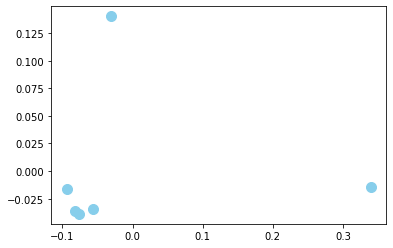

In [44]:
data=citeseer_A0.evaluate(write_confusion=True)
run_pca(data)

In [45]:
#citeseer_p
device2P = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dataset2P = citeseer_P
data2P = citeseer_P[0].to(device2P)
citeseer_P0 = accuracy(device2P, dataset2P, data2P)
citeseer_P0.train(500)

             
Training the model



             
Evaluating the model

Accuracy: 0.6900


,pca-one,pca-two
0,0.003407,-0.027584
1,-0.103836,-0.204359
2,-0.380539,-0.145688
3,-0.229365,-0.057029
4,0.670447,-0.169663
5,0.039886,0.604324


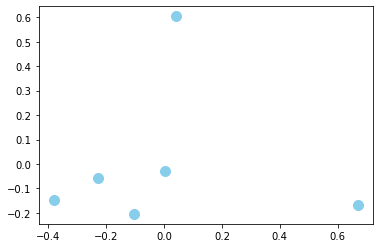

In [46]:
data=citeseer_P0.evaluate(write_confusion=True)
run_pca(data)

In [47]:
#pubmed_A
device3A = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dataset3A = pubmed_A
data2A = pubmed_A_data.to(device3A)
pubmed_A0 = accuracy(device3A, dataset3A, data2A)
pubmed_A0.train(500)

             
Training the model



             
Evaluating the model

Accuracy: 0.6719


,pca-one,pca-two
0,0.622379,-0.049905
1,-0.217114,0.272574
2,-0.405265,-0.222669


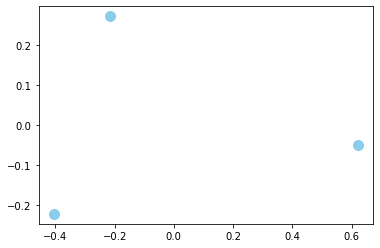

In [48]:
data=pubmed_A0.evaluate(write_confusion=True)
run_pca(data)

In [49]:
#pubmed_P
device3P = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dataset3P = pubmed_P
data2P = pubmed_P[0].to(device3P)
pubmed_P0 = accuracy(device3P, dataset3P, data2P)
pubmed_P0.train(500)

             
Training the model



             
Evaluating the model

Accuracy: 0.7760


,pca-one,pca-two
0,0.563727,-0.154659
1,-0.444304,-0.325211
2,-0.119423,0.479870


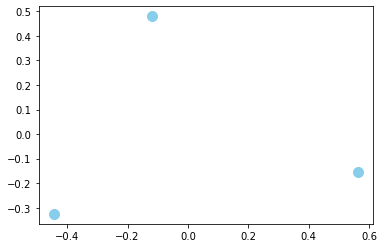

In [50]:
data=pubmed_P0.evaluate(write_confusion=True)
run_pca(data)

## result

In [15]:
accuracy = {'cora_A': [0.3013,  0.1262, 0.6983, 0.6886], 'cora_P': [0.1440, 0.0910, 0.7940, 0.7670], 'citeseer_A':[0.1579, 0.1371, 0.5490, 0.5669], 'citeseer_P' : [0.0780, 0.0770, 0.7130, 0.6150], 'pubmed_A':[0.3870, 0.3997, 0.7364, 0.7021], 'pubmed_P': [0.4070, 0.4130, 0.7740, 0.7240]}
result = pd.DataFrame.from_dict(data=accuracy, orient='index', columns=['lr = 0.1, epoch 200, nll', 'lr = 0.01, epoch 500, nll', 'lr = 0.01, epoch 500, ce', 'lr = 0.01, epoch 100, ce'])
display(result)

,"lr = 0.1, epoch 200, nll","lr = 0.01, epoch 500, nll","lr = 0.01, epoch 500, ce","lr = 0.01, epoch 100, ce"
cora_A,0.3013,0.1262,0.6983,0.6886
cora_P,0.1440,0.0910,0.7940,0.7670
citeseer_A,0.1579,0.1371,0.5490,0.5669
citeseer_P,0.0780,0.0770,0.7130,0.6150
pubmed_A,0.3870,0.3997,0.7364,0.7021
pubmed_P,0.4070,0.4130,0.7740,0.7240


## tasks

1. confusion matrix for each class, what is the accuracy vs. the miss (real class vs fake class)
 - pass everything into numpy array and use sklearn.metrics.confusion_matrix
2. histogram according to the degree (the number of edges for each node) vs average accuracy per bucket 
3. remove one data point at a time, define a random training set and see if there is an anomaly point 

In [38]:
pred = cora_A0.model(data1A).argmax(dim=1)
new = confusion_matrix(data1A.y[data1A.test_mask].numpy(), pred[data1A.test_mask].numpy(), normalize='true')
pd.DataFrame(data=new)
# diagonal = accuracy 

,0,1,2,3,4,5,6
0,0.757576,0.022727,0.000000,0.083333,0.083333,0.045455,0.007576
1,0.022989,0.816092,0.022989,0.103448,0.011494,0.022989,0.000000
2,0.000000,0.012422,0.857143,0.099379,0.012422,0.012422,0.006211
3,0.037415,0.010204,0.000000,0.891156,0.044218,0.013605,0.003401
4,0.019108,0.000000,0.000000,0.101911,0.840764,0.031847,0.006369
5,0.036364,0.027273,0.018182,0.009091,0.018182,0.863636,0.027273
6,0.135593,0.000000,0.000000,0.050847,0.016949,0.084746,0.711864


In [39]:
new = confusion_matrix(data1A.y[data1A.test_mask].numpy(), pred[data1A.test_mask].numpy())
original = pd.DataFrame(data=new)
display(original)
print(pd.DataFrame(data=new).sum(axis=0))

,0,1,2,3,4,5,6
0,100,3,0,11,11,6,1
1,2,71,2,9,1,2,0
2,0,2,138,16,2,2,1
3,11,3,0,262,13,4,1
4,3,0,0,16,132,5,1
5,4,3,2,1,2,95,3
6,8,0,0,3,1,5,42


0    128
1     82
2    142
3    318
4    162
5    119
6     49
dtype: int64
